### 14. 크롤러 만들기

<br>

14.1 기본 웹 크롤러  
14.2 고급 웹 크롤러  
14.3 셀레늄을 이용한 크롤러

---

### 14.1 기본 웹 크롤러

##### 웹 크롤링 순서 
##### Request로 웹페이지 추출 -> lxml로 웹페이지 스크래핑 -> sqlite3 DB에 데이터 저장

<br>

##### 전형적인 목록/상세 패턴을 가진 웹사이트를 기반으로 도서정보 추출 크롤러를 제작하는게 목표  
##### 크롤링 대상은 한빛 미디어 사이트의 "새로나온 책" 목록  
##### 목록 페이지는 제목과 저자 정보
##### 상세 페이지의 출간일, 페이지, ISBN, 물류 코드, 책 소개 등의 정보 중에서 제목, 가격, 목차 정보를 추출함

##### < 3.7.1.1.python_crawler_1 >

##### 목록 페이지에서 퍼머 링크 목록을 추출함
##### 크롤링 대상 페이지 : http://www.hanbit.co.kr/store/books/new_book_list.html
##### ctrl + f 후 .view_box a 검색해보면 쉽게 찾을 수 있음

In [1]:
import requests
import lxml.html

response = requests.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
root = lxml.html.fromstring(response.content)
for a in root.cssselect('.view_box a'):
    url = a.get('href')
    print(url)

/store/books/look.php?p_code=B2499110389
/store/books/look.php?p_code=B2499110389
/store/books/look.php?p_code=B7623190015
/store/books/look.php?p_code=B7623190015
/store/books/look.php?p_code=B4300598719
javascript:;
/store/books/look.php?p_code=B4300598719
/store/books/look.php?p_code=B9108907099
/store/books/look.php?p_code=B9108907099
/store/books/look.php?p_code=B7015117381
javascript:;
/store/books/look.php?p_code=B7015117381
/store/books/look.php?p_code=B7448632539
javascript:;
/store/books/look.php?p_code=B7448632539
/store/books/look.php?p_code=B3148701816
/store/books/look.php?p_code=B3148701816
/store/books/look.php?p_code=B2591303726
/store/books/look.php?p_code=B2591303726
/store/books/look.php?p_code=B9602652686
javascript:;
/store/books/look.php?p_code=B9602652686
/store/books/look.php?p_code=B7468885216
javascript:;
/store/books/look.php?p_code=B7468885216
/store/books/look.php?p_code=B1108557246
/store/books/look.php?p_code=B1108557246
/store/books/look.php?p_code=B935

##### < 3.7.1.2.python_crawler_2 >

##### 목록 페이지에서 퍼머 링크 목록을 추출함
##### 1) javascript로 시작하는 목록을 제거해야 함 
##### 2) 상대 URL을 절대 URL로 변환해야 함

In [2]:
import requests
import lxml.html

response = requests.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
root = lxml.html.fromstring(response.content)
root.make_links_absolute(response.url) # 모든 링크를 절대 URL로 변환

for a in root.cssselect('.view_box .book_tit a'): # 목록에서 javascript 제거
    url = a.get('href')                           
    print(url)

https://www.hanbit.co.kr/store/books/look.php?p_code=B2499110389
https://www.hanbit.co.kr/store/books/look.php?p_code=B7623190015
https://www.hanbit.co.kr/store/books/look.php?p_code=B4300598719
https://www.hanbit.co.kr/store/books/look.php?p_code=B9108907099
https://www.hanbit.co.kr/store/books/look.php?p_code=B7015117381
https://www.hanbit.co.kr/store/books/look.php?p_code=B7448632539
https://www.hanbit.co.kr/store/books/look.php?p_code=B3148701816
https://www.hanbit.co.kr/store/books/look.php?p_code=B2591303726
https://www.hanbit.co.kr/store/books/look.php?p_code=B9602652686
https://www.hanbit.co.kr/store/books/look.php?p_code=B7468885216
https://www.hanbit.co.kr/store/books/look.php?p_code=B1108557246
https://www.hanbit.co.kr/store/books/look.php?p_code=B9354330938
https://www.hanbit.co.kr/store/books/look.php?p_code=B3006151946
https://www.hanbit.co.kr/store/books/look.php?p_code=B2388883228
https://www.hanbit.co.kr/store/books/look.php?p_code=B4766499846
https://www.hanbit.co.kr/

##### < 3.7.1.3.python_crawler_3 >

##### 목록 페이지에서 퍼머 링크 목록을 추출함

<br>

##### scrape_list_page() 함수
##### URL 목록을 추출하기 위해 정의한 함수
##### 함수의 반환값은 list처럼 반복가능한 제너레이터로 구현함

In [3]:
import requests
import lxml.html

"""크롤러의 메인 처리"""    
def main():    
    session = requests.Session() # 여러 페이지에서 크롤링을 위해 Session 사용    
    response = session.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
    urls = scrape_list_page(response) # 제너레이터 추출
    
    for url in urls: # 제너레이터는 list처럼 사용 가능
        print(url)
        print('-'*70)

def scrape_list_page(response):
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)
    for a in root.cssselect('.view_box .book_tit a'):
        url = a.get('href')
        yield url # yield 구문으로 제너레이터의 요소 반환
                  # 작업과 대기를 반복

if __name__ == '__main__':
    main()

https://www.hanbit.co.kr/store/books/look.php?p_code=B2499110389
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B7623190015
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B4300598719
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B9108907099
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B7015117381
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B7448632539
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_code=B3148701816
----------------------------------------------------------------------
https://www.hanbit.co.kr/store/books/look.php?p_

##### < 3.7.2.1.python_crawler_4 >

##### 상세 페이지 스크래핑
##### 1) 개발자 도구로 CSS Selector를 확인
 - 타이틀 : .store _product_info_box h3
 - 가격 : .pbr strong
 - 목차 : #tabs_3 .hanbit_edit_view 내부의 p 태그들

##### 2) response를 매개변수로 scrape_detail_page()를 호출해서 책의 상세 정보를 추출함
##### 3) scrape_detail_page() 함수에서는 CSS Selector를 사용해서 스크래핑
##### 4) 제목과 가격은 root. cssselect() 함수로 추출한 리스트의 첫 번째 요소에서 문자열을 추출
##### 5) 목차는 List Comprehension을 사용해 목차를 리스트로 추출함

In [4]:
import requests
import lxml.html

def main():    
    session = requests.Session() # 여러 페이지에서 크롤링을 위해 Session 사용
    response = session.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
    urls = scrape_list_page(response) # 제너레이터 추출
    for url in urls:
        response = session.get(url) # Session을 사용해 상세 페이지를 추출
        ebook = scrape_detail_page(response) # 상세 페이지(response)에서 상세 정보를 추출
        print(ebook) # 상세 정보(ebook) 출력
        break # 리스트 하나만 출력함. 지우면 전부 출력

def scrape_list_page(response):
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)
    for a in root.cssselect('.view_box .book_tit a'):
        url = a.get('href')
        yield url
        
"""상세 페이지(Response)에서 책 정보를 dict로 추출"""
def scrape_detail_page(response):    
    root = lxml.html.fromstring(response.content)
    ebook = {
        'url': response.url,
        'title': root.cssselect('.store_product_info_box h3')[0].text_content(),
        'price': root.cssselect('.pbr strong')[0].text_content(),
        'content': [p.text_content()\
            for p in root.cssselect('#tabs_3 .hanbit_edit_view p')]
    }
    return ebook

if __name__ == '__main__':
    main()

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B2499110389', 'title': 'STEM CookBook, 문제 해결력을 키우는 정역학', 'price': '30,000', 'content': ['', '\r\n\t\tPART 1 _ 평면에서 기초 다지기\r\n', '\xa0', '\r\n\t\t1장. 정역학 기초\r\n', '1.1 단위\xa0', '1.2 스칼라와 벡터', '1.3 강체와 질점\xa0', '1.4 무게중심, 질량중심, 도심', '1.5 뉴턴의 법칙', '1.6 정역학 맛보기', '연습문제', '\xa0', '\r\n\t\t2장. 1차원 힘\r\n', '2.1 힘이란', '2.2 힘의 분류\xa0', '2.3 힘의 전달성 원리\xa0', '2.4 1차원 힘 평형\xa0', '2.5 도르래', '종합예제', '연습문제', '\xa0', '\r\n\t\t3장. 2차원 힘\r\n', '3.1 힘 벡터 및 힘의 성분', '3.2 자유물체도\xa0', '3.3 2차원 힘 평형', '3.4 라미의 정리', '종합예제', '연습문제', '\xa0', '\r\n\t\t4장. 2차원 모멘트\r\n', '4.1 모멘트란', '4.2 짝힘과 모멘', '4.3 모멘트의 종류', '4.4 비공점력계의 평형', '4.5 지레의 원리', '종합예제', '연습문제', '\xa0', '\r\n\t\t5장. 평면트러스\r\n', '5.1 이력부재의 진화', '5.2 평면트러스', '5.3 평면트러스 해석\xa0', '5.4 절점법', '5.5 단면법', '종합예제', '연습문제', '\xa0', '\xa0', '\r\n\t\tPART 2 _ 평면에서 입체로 도약하기\r\n', '\xa0', '\r\n\t\t6장. 면적 1차 모멘트\r\n', '6.1 분포력\xa0', '6.2 면적 1차 모멘트', '6.3 단순 형상의 도심', '6.4 복합 형상의 도심\xa0', '6.5 파푸스의 정리', '종합예제'

##### < 3.7.2.2.python_crawler_5 >

##### 상세 페이지 스크래핑

<br>

##### normalize_space() 함수
##### 목차에 포함된 공백을 제거하기 위해 정의한 함수
##### List Comprehension 구문에 조건을 추가해서 빈 문자열을 제거함

In [5]:
import requests
import lxml.html
import re

def main():    
    session = requests.Session()  # 여러 페이지에서 크롤링을 위해 Session 사용    
    response = session.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
    urls = scrape_list_page(response) # 제너레이터 추출
    for url in urls:
        response = session.get(url) # Session을 사용해 상세 페이지를 추출
        ebook = scrape_detail_page(response) # 상세 페이지에서 상세 정보를 추출
        print(ebook) # 상세 정보 출력
        #break  # 리스트 하나만 출력함. 지우면 전부 출력

def scrape_list_page(response):
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)
    for a in root.cssselect('.view_box .book_tit a'):
        url = a.get('href')
        yield url

"""상세 페이지(Response)에서 책 정보를 dict로 추출"""        
def scrape_detail_page(response):    
    root = lxml.html.fromstring(response.content)
    ebook = {
        'url': response.url,
        'title': root.cssselect('.store_product_info_box h3')[0].text_content(),
        'price': root.cssselect('.pbr strong')[0].text_content(),
        'content': [normalize_spaces(p.text_content())
            for p in root.cssselect('#tabs_3 .hanbit_edit_view p')
            if normalize_spaces(p.text_content()) != '']
    }
    return ebook

"""연결된 공백을 하나의 공백으로 변경"""
def normalize_spaces(s):    
    return re.sub(r'\s+', ' ', s).strip() # 정규식!

if __name__ == '__main__':
    main()

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B2499110389', 'title': 'STEM CookBook, 문제 해결력을 키우는 정역학', 'price': '30,000', 'content': ['PART 1 _ 평면에서 기초 다지기', '1장. 정역학 기초', '1.1 단위', '1.2 스칼라와 벡터', '1.3 강체와 질점', '1.4 무게중심, 질량중심, 도심', '1.5 뉴턴의 법칙', '1.6 정역학 맛보기', '연습문제', '2장. 1차원 힘', '2.1 힘이란', '2.2 힘의 분류', '2.3 힘의 전달성 원리', '2.4 1차원 힘 평형', '2.5 도르래', '종합예제', '연습문제', '3장. 2차원 힘', '3.1 힘 벡터 및 힘의 성분', '3.2 자유물체도', '3.3 2차원 힘 평형', '3.4 라미의 정리', '종합예제', '연습문제', '4장. 2차원 모멘트', '4.1 모멘트란', '4.2 짝힘과 모멘', '4.3 모멘트의 종류', '4.4 비공점력계의 평형', '4.5 지레의 원리', '종합예제', '연습문제', '5장. 평면트러스', '5.1 이력부재의 진화', '5.2 평면트러스', '5.3 평면트러스 해석', '5.4 절점법', '5.5 단면법', '종합예제', '연습문제', 'PART 2 _ 평면에서 입체로 도약하기', '6장. 면적 1차 모멘트', '6.1 분포력', '6.2 면적 1차 모멘트', '6.3 단순 형상의 도심', '6.4 복합 형상의 도심', '6.5 파푸스의 정리', '종합예제', '연습문제', '7장. 면적 2차 모멘트', '7.1 면적 2차 모멘트', '7.2 단순 형상의 면적 2차 모멘트', '7.3 복합 형상의 면적 2차 모멘트', '7.4 면적 상승 모멘트', '종합예제', '연습문제', '8장. 3차원 힘과 모멘트', '8.1 3차원 문제', '8.2 3차원 힘과 모멘트', '8.3 3차원 평형', '8.4 입체트러스'

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B7015117381', 'title': '풀스택 서버리스 :  리액트, AWS, 그래프QL을 이용한 최신 애플리케이션 개발', 'price': '18,900', 'content': ['chapter 1 서버리스 컴퓨팅 시대의 풀스택 개발', '1.1 현대적인 서버리스 철학', '1.2 AWS 소개', '1.3 AWS Amplify CLI 소개', '1.4 마치며', 'chapter 2 AWS Amplify 시작하기', '2.1 서버리스 함수 생성과 배포', '2.2 API 추가', '2.3 새 API와 통신', '2.4 다른 API를 호출하도록 함수 수정', '2.5 마치며', 'chapter 3 첫 번째 애플리케이션 만들기', '3.1 그래프QL 소개', '3.2 그래프QL API 생성', '3.3 그래프QL API와 통신 및 확인', '3.4 리액트 애플리케이션 구축', '3.5 마치며', 'chapter 4 인증 소개', '4.1 Amazon Cognito 소개', '4.2 리액트 애플리케이션 생성과 Amplify 추가', '4.3 애플리케이션 빌드', '4.4 마치며', 'chapter 5 사용자 정의 인증 전략', '5.1 protectedRoute Hook 만들기', '5.2 Form 컴포넌트 만들기', '5.3 마치며', 'chapter 6 서버리스 함수 심화 1', '6.1 이벤트 소스와 데이터 구조', '6.2 IAM 권한 및 트리거 설정', '6.3 기본 프로젝트 생성', '6.4 Post Confirmation Lambda Trigger 추가', '6.5 AWS Lambda와 Amazon S3를 이용한 동적 이미지 크기 조정', '6.6 마치며', 'chapter 7 서버리스 함수 심화 2', '7.1 구축할 애플리케이션', '7.2 시작하기', '7.3 인증 및 그룹 권한 추가', '7.4 데이터베이스 추가', '7.5 API 

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B1108557246', 'title': '상식의 재구성', 'price': '19,800', 'content': ['이 책을 읽는 독자를 위한 독법 가이드', '프롤로그 2020 전 세계 코로나 일제고사', '1장 불평등 퍼즐', '2장 미디어 유토피아 디스토피아', '3장 민주주의 멀미', '4장 독일의 경우', '5장 이념 트라우마', '6장 일본 딜레마', '7장 한국인은 누구인가', '책을 마치며']}
{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B9354330938', 'title': '업무에 바로 쓰는 SQL 튜닝', 'price': '19,800', 'content': ['1장. MySQL과 MariaDB 개요', '1.1 현황', '1.2 상용 RDBMS와의 차이점', '1.3 MySQL과 MariaDB 튜닝의 중요성', '1.4 마치며', '2장. SQL 튜닝 용어를 직관적으로 이해하기', '2.1 물리 엔진과 오브젝트 용어', '2.2 논리적인 SQL 개념 용어', '2.3 개념적인 튜닝 용어', '2.4 마치며', '3장. SQL 튜닝의 실행 계획 파헤치기', '3.1 실습 환경 구성하기', '3.2 실행 계획 수행', '3.3 프로파일링', '3.4 마치며', '4장. 악성 SQL 튜닝으로 초보자 탈출하기', '4.1 SQL 튜닝 준비하기', '4.2 SQL 문 단순 수정으로 착한 쿼리 만들기', '4.3 테이블 조인 설정 변경으로 착한 쿼리 만들기', '4.4 마치며', '5장. 악성 SQL 튜닝으로 전문가 되기', '5.1 SQL 문 재작성으로 착한 쿼리 만들', '5.2 인덱스 조정으로 착한 쿼리 만들기', '5.3 적절한 테이블 및 열 속성 설정으로 착한 쿼리 만들기', '5.4 마치며']}
{'url': 'https://www.hanbit.co.kr/st

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B3573121629', 'title': '처음 배우는 네트워크 보안', 'price': '25,200', 'content': ['CHAPTER 1 네트워크 보안 시작', '1.1 네트워크 보안과 보안 관제 필요성', '1.2 보안 조직 구성', '1.3 보안 관제 센터 구축', '1.4 보안 관제 실무', '1.5 마치며', 'CHAPTER 2 네트워크 보안 배경지식', '2.1 네트워크 기본 이론', '2.2 네트워크 장비', '2.3 네트워크 보안 시스템', '2.4 마치며', 'CHAPTER 3 네트워크 보안 실습 환경 구축', '3.1 네트워크 구축', '3.2 가상 머신 환경 구축', '3.3 네트워크 시뮬레이터를 이용한 네트워크 구성', '3.4 마치며', 'CHAPTER 4 방화벽', '4.1 방화벽 장비 제작', '4.2 방화벽 설치 및 설정', '4.3 방화벽 운영', '4.4 마치며', 'CHAPTER 5 네트워크 침입 탐지/차단 시스템', '5.1 NIDS/NIPS 장비 제작', '5.2 NIDS/NIPS 네트워크 구성', '5.3 Suricata', '5.4 마치며', 'CHAPTER 6 호스트 기반 침입 탐지/차단 시스템', '6.1 OSSEC 설치 및 설정', '6.2 OSSEC 에이전트 관리', '6.3 마치며', 'CHAPTER 7 웹 방화벽', '7.1 웹 방화벽 구축', '7.2 웹 방화벽 정책 관리', '7.3 마치며', 'CHAPTER 8 보안 관제 시스템', '8.1 보안 관제 구성', '8.2 ELK를 통한 보안 관제', '8.3 마치며', 'CHAPTER 9 보안 취약점 점검을 위한 도구', '9.1 네트워크 보안 취약점 진단', '9.2 네트워크 트래픽 분석', '9.3 마치며', 'CHAPTER 10 네트워크 보안 관제 실무', '10.1 보안 관제 기본 운영', '10.2 임계치 기반 공격 탐지와 대응'

##### < 3.7.3.1.python_crawler_final >

##### 상세 페이지 스크래핑

<br>

##### main() 함수의 time.sleep() 구문
##### 대상 서버에 부하를 주지 않도록 하기 위해 하나의 작업이 끝나면 일정 시간동안 대기하게 함

<br>

##### main() 함수의 break 구문
##### 대상 서버에 부하를 주지 않도록 하기 위해 상세 정보 하나만 읽고 멈춤
##### break문을 지우면 상세 정보 전체가 크롤링됨

In [6]:
import time
import requests
import lxml.html
import re

def main():
    session = requests.Session()  # 여러 페이지에서 크롤링을 위해 Session 사용   
    response = session.get('http://www.hanbit.co.kr/store/books/new_book_list.html')
    urls = scrape_list_page(response)  # 제너레이터 추출
    for url in urls:
        time.sleep(1) # 1초간 대기
        response = session.get(url)  # Session을 사용해 상세 페이지를 추출
        ebook = scrape_detail_page(response)  # 상세 페이지에서 상세 정보를 추출
        print(ebook)  # 상세 정보 출력
        #break   # 리스트 하나만 출력함. 지우면 전부 출력

def scrape_list_page(response):
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)
    for a in root.cssselect('.view_box .book_tit a'):
        url = a.get('href')
        yield url        
        
"""상세 페이지(Response)에서 책 정보를 dict로 추출"""      
def scrape_detail_page(response):
    root = lxml.html.fromstring(response.content)
    ebook = {
        'url': response.url,
        'title': root.cssselect('.store_product_info_box h3')[0].text_content(),
        'price': root.cssselect('.pbr strong')[0].text_content(),
        'content': [normalize_spaces(p.text_content())
            for p in root.cssselect('#tabs_3 .hanbit_edit_view p')
            if normalize_spaces(p.text_content()) != '']
    }
    return ebook        
        
"""연결된 공백을 하나의 공백으로 변경"""    
def normalize_spaces(s):    
    return re.sub(r'\s+', ' ', s).strip()        
        
if __name__ == '__main__':
    main()       
    

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B2499110389', 'title': 'STEM CookBook, 문제 해결력을 키우는 정역학', 'price': '30,000', 'content': ['PART 1 _ 평면에서 기초 다지기', '1장. 정역학 기초', '1.1 단위', '1.2 스칼라와 벡터', '1.3 강체와 질점', '1.4 무게중심, 질량중심, 도심', '1.5 뉴턴의 법칙', '1.6 정역학 맛보기', '연습문제', '2장. 1차원 힘', '2.1 힘이란', '2.2 힘의 분류', '2.3 힘의 전달성 원리', '2.4 1차원 힘 평형', '2.5 도르래', '종합예제', '연습문제', '3장. 2차원 힘', '3.1 힘 벡터 및 힘의 성분', '3.2 자유물체도', '3.3 2차원 힘 평형', '3.4 라미의 정리', '종합예제', '연습문제', '4장. 2차원 모멘트', '4.1 모멘트란', '4.2 짝힘과 모멘', '4.3 모멘트의 종류', '4.4 비공점력계의 평형', '4.5 지레의 원리', '종합예제', '연습문제', '5장. 평면트러스', '5.1 이력부재의 진화', '5.2 평면트러스', '5.3 평면트러스 해석', '5.4 절점법', '5.5 단면법', '종합예제', '연습문제', 'PART 2 _ 평면에서 입체로 도약하기', '6장. 면적 1차 모멘트', '6.1 분포력', '6.2 면적 1차 모멘트', '6.3 단순 형상의 도심', '6.4 복합 형상의 도심', '6.5 파푸스의 정리', '종합예제', '연습문제', '7장. 면적 2차 모멘트', '7.1 면적 2차 모멘트', '7.2 단순 형상의 면적 2차 모멘트', '7.3 복합 형상의 면적 2차 모멘트', '7.4 면적 상승 모멘트', '종합예제', '연습문제', '8장. 3차원 힘과 모멘트', '8.1 3차원 문제', '8.2 3차원 힘과 모멘트', '8.3 3차원 평형', '8.4 입체트러스'

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B7448632539', 'title': '한 권으로 배우는 작고 예쁜 꽃자수', 'price': '16,200', 'content': ['프롤로그', '이 책을 보는 방법', 'Basic. 꽃자수와 친해지는 시간', '1 꽃자수를 위한 준비물', '2 꽃자수 준비하기', '3 꽃자수 표현하기', 'Part 1. 차근차근 익히는 시간', '1 꽃을 만드는 스티치', '2 잎을 만드는 스티치', '3 줄기를 만드는 스티치', '4 꽃을 꾸미는 스티치', '5 스티치 연습', 'Part 2. 꽃을 수놓는 시간', '1 보라색과 파란색 꽃', '라벤더(응용: 라벤더 리스)', '블루스타', '나비수국', '클레마티스', '2 노란색과 주황색 꽃', '해바라기(응용: 해바라기 패턴)', '유채꽃', '아이슬란드 포피', '아이슬란드 포피 꽃병', '개나리', '3 분홍색 꽃', '사과꽃', '매화', '벚꽃', '소국', '4 빨간색 꽃', '동백(응용: 카멜리아힐 동백)', '채송화', '꽃양귀비', '카네이션', '5 흰색 꽃', '스노우드롭', '토끼풀', '백합', '왁스플라워', '6 특별한 색상 조합', '네 가지 화분(응용: 히야신스 화분)', '가을 꽃수레(응용: 봄날 꽃수레)', '핼러윈 호박', '크리스마스 꽃다발(응용: 크리스마스 리스, 크리스마스 트리)', '부록 | 실물 크기 도안']}
{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B3148701816', 'title': 'IT CookBook, 처음 만나는 회로이론(2판)', 'price': '23,000', 'content': ['CHAPTER 01 회로의 기초', 'SECTION 1.1 회로 소자', 'SECTION 1.2 회로 설계의 이해', 'SECTION 1.3 등가 저항과 개방/단락 회로', '연습문제', '

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B3006151946', 'title': 'IT CookBook, C로 배우는 쉬운 자료구조(4판)', 'price': '29,000', 'content': ['Chapter 01 자료구조 소개', '01 자료구조의 이해', '02 자료의 표현', '03 자료의 추상화', '04 알고리즘의 이해', '05 알고리즘의 표현 방법', '06 알고리즘의 성능 분석', '요약 / 연습문제', 'Chapter 02 자료구조 구현을 위한 C 프로그래밍 기법', '01 배열', '02 포인터', '03 구조체', '04 재귀호출', '요약 / 연습문제', 'Chapter 03 순차 자료구조와 선형 리스트', '01 순차 자료구조와 선형 리스트의 이해', '02 선형 리스트의 연산과 알고리즘', '03 선형 리스트의 응용 및 구현', '응용예제', '요약 / 연습문제', 'Chapter 04 연결 자료구조와 연결 리스트', '01 연결 자료구조와 연결 리스트의 이해', '02 단순 연결 리스트', '03 원형 연결 리스트', '04 이중 연결 리스트', '05 연결 리스트의 응용 및 구현', '응용예제', '요약 / 연습문제', 'Chapter 05 스택', '01 스택의 이해', '02 스택의 구현', '03 스택의 응용', '응용예제', '요약 / 연습문제', 'Chapter 06 큐', '01 큐의 이해', '02 큐의 구현', '03 데크', '04 큐의 응용', '응용예제', '요약 / 연습문제', 'Chapter 07 트리', '01 트리의 이해', '02 이진 트리', '03 이진 트리의 구현', '04 이진 트리의 순회', '05 이진 탐색 트리', '06 균형 이진 탐색 트리', '07 히프의 개념과 연산 및 구현', '응용예제', '요약 / 연습문제', 'Chapter 08 그래프', '01 그래프의 구조', '02 그래프의 구현', '03 그래프

{'url': 'https://www.hanbit.co.kr/store/books/look.php?p_code=B7132069963', 'title': 'IT CookBook, 난생처음 파이썬 프로그래밍', 'price': '24,000', 'content': ['Chapter 01 파이썬 비긴즈', '01 프로그래밍 언어란?', '02 파이썬이란?', '03 파이썬 설치하고 실행하기', '04 파이썬 IDLE 활용하기', 'Chapter 02 변수', '01 변수란?', '02 변수 이름 짓기', '03 값을 입력받는 input() 함수', '[실전 예제] 거북이가 나오는 프로그램', 'Chapter 03 연산자', '01 산술 연산자', '02 대입 연산자', '03 비교 연산자와 논리 연산자', '04 연산자의 우선순위', '[실전 예제] 거북이를 그리는 펜의 변화', '[실전 예제] 입력한 값만큼 거북이 움직이기', 'Chapter 04 데이터형과 문자열', '01 데이터형이란?', '02 데이터형의 종류', '03 문자열 알아보기', '[실전 예제] 모험을 떠나는 거북이', 'Chapter 05 조건문', '01 조건문의 기초 다지기', '02 조건문 알아보기', '[실전 예제] 사춘기 거북이를 지도하기', 'Chapter 06 반복문', '01 for문 기초 다지기', '02 for문 활용하기', '03 while문이란?', '[실전 예제] 거북이 무늬의 벽지 만들기', 'Chapter07 리스트, 튜플, 딕셔너리', '01 리스트 기초', '02 리스트 활용하기', '03 튜플', '04 딕셔너리', '[실전 예제] 100마리의 거북이 쇼', 'Chapter 08 함수를 이용한 고급 프로그래밍', '01 함수 이해하기', '02 함수에 매개변수를 전달하고 값 반환하기', '03 지역변수와 전역변수', '[실전 예제] 훈민정음 그래픽 디자인', 'Chapter09 파일 읽기와 쓰기', '01 파일을 사용하는 이유', '02 파일 읽기', '03 파일

---

### 14.2 고급 웹 크롤러

##### < 3.8.1.1.daum_news_list_1 >

##### 다음뉴스에서 IT목록을 가져옴

<br>

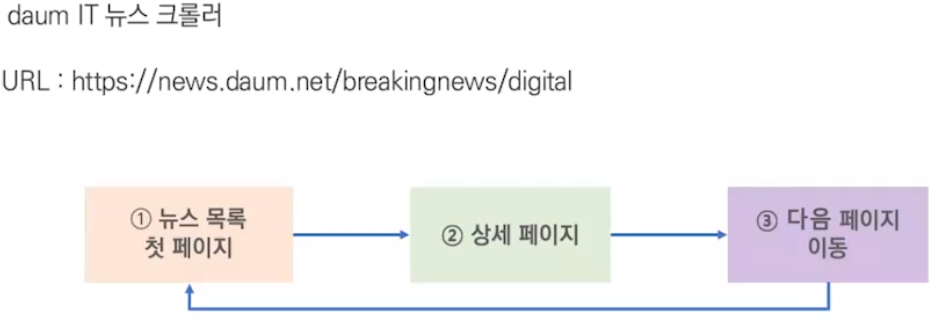

In [7]:
import requests
import lxml.html
import pandas as pd
import sqlite3
from pandas.io import sql
import os

REG_DATE = '20210715' # 현재 날짜

response = requests.get('https://news.daum.net/breakingnews/digital?regDate={}'.format(REG_DATE))
root = lxml.html.fromstring(response.content)

for li in root.xpath('//*[@id="mArticle"]/div[3]/ul/li'):
    a = li.xpath('div/strong/a')[0]
    url = a.get('href')
    print(url, a.text) 

https://v.daum.net/v/20210715205010526 '넷플릭스 항소 제기' SKB "적절한 시기 반소할 것"
https://v.daum.net/v/20210715204802493 코로나19 시대, 국민과 소통 강화하기 위한 행안부의 노력
https://v.daum.net/v/20210715204200395 '망 사용료' 1심 패소한 넷플릭스 항소
https://v.daum.net/v/20210715203145247 '만유인력의 법칙' 활용 땐 책상 앞에 앉아 지구의 무게 잴 수 있다고? [전문가의 세계 - 이종필의 과학자의 발상법 (18)]
https://v.daum.net/v/20210715203145246 넷플릭스 "망 이용대가 강요, 인터넷 생태계 위협"..항소
https://v.daum.net/v/20210715203003219 SK브로드밴드 "넷플릭스 망이용대가 거부시 반소 청구"
https://v.daum.net/v/20210715202543182 "그 많은 돈을 어떻게" 모텔 종업원에서 인생역전, 2조원 '잭팟'
https://v.daum.net/v/20210715202443176 엔씨소프트 블레이드앤소울2, 19일 출시일 공개?..사전 예약 종료 안내
https://v.daum.net/v/20210715200655907 '분해까지 80일'..케나프 활용 친환경플라스틱 개발 추진
https://v.daum.net/v/20210715200606894 '구글 갑질방지법' 20일에 다시 논의.."방통위·공정위 관할 다툼 조율해야"
https://v.daum.net/v/20210715200417863 방글라데시 원자로 핵심설비, 한국기술로 만든다
https://v.daum.net/v/20210715200416862 헬릭스미스, 경영권 방어.. 이사진 해임안 결국 부결
https://v.daum.net/v/20210715200413859 [D파이오니어를 만나다] "법률 AI번역서비스, 과학·의학으로 확장.. 소통혁신 기여할 것"
https

##### < 3.8.1.2.daum_news_list_2 >

##### 다음 뉴스 목록의 상세 페이지를 출력함

<br>

##### get_detail() 함수
##### 특수문자를 제거하기 위해 정의한 함수

In [8]:
import requests
import lxml.html
import pandas as pd
import sqlite3
from pandas.io import sql
import os

import re
import string

def get_detail(url):
    body = []
    punc = '[!"#$%&\'()*+,-./:;<=>?[\]^_`{|}~“”·]' # 특수문자 제거 리스트
    response = requests.get(url)
    root = lxml.html.fromstring(response.content)
    for p in root.xpath('//*[@id="harmonyContainer"]/section/p'):
        if p.text: # 체크
            body.append(re.sub(punc, '', p.text)) # 특수문자 제거
    full_body = ' '.join(body)
    
    return full_body

get_detail('https://news.v.daum.net/v/20200505000102404')


'LG전자 스마트TV 리모컨 클릭 한 번에 왓챠플레이가 연결된다 왓챠와 LG전자는 LG 2019년형 스마트TV부터 스마트TV 리모컨에서 영화 버튼을 클릭하면 왓챠플레이 서비스가 바로 연동되도록 지원한다 왓챠플레이를 구독하는 고객 편의성을 강화했다 LG 신형 스마트TV를 보유한 왓챠플레이 고객은 편리하게 서비스를 이용할 수 있게 됐다 기존에도 삼성전자LG전자 스마트TV 메뉴와 유료방송 셋톱박스 등을 통해 왓챠플레이를 시청할 수 있었다 왓챠플레이 애플리케이션앱을 찾아야 하는 번거로움이 있었다 박태훈 왓챠 대표는 국내외 제조사는 물론 통신사 방송사와 서비스 협업을 논의 중이라며 왓챠플레이를 더 쉽게 접할 수 있도록 계속 협력해나갈 것이라고 말했다 왓챠플레이뿐만 아니라 웨이브 넷플릭스 디즈니플러스디즈니 등 대다수 온라인동영상서비스OTT가 스마트TV유료방송과 고객 접점을 확대하는 추세다 스마트폰태블릿PC 등 모바일은 물론 TV와 PC 등 다양한 디바이스에서 클릭 한 번에 서비스를 이용하도록 지원 접근성을 강화했다 고객 접점을 확대해 가입 유인을 늘리기 위한 전략이다 넷플릭스는 LG유플러스와 LG헬로비전 딜라이브 등 IPTV케이블TV와 서비스를 연동 쉽게 볼 수 있도록 지원한다 삼성LG 스마트TV 앱 또는 리모컨에서 넷플릭스NETFLIX 버튼 클릭 한 번에 서비스를 이용할 수 있도록 지원한다 웨이브와 CJ ENM 티빙TVING 등 국산 OTT는 물론 미국유럽 등 해외에서 서비스를 제공 중인 디즈니 역시 삼성LG전자 스마트TV에서 서비스를 제공한다 유료방송 플랫폼 차원에서 OTT와 제휴도 적극적이다 KT스카이라이프는 통합 OTT 서비스 토핑 출시 1주년을 맞아 국내 최대 애니메이션 스트리밍 플랫폼 라프텔 서비스를 추가했다 이달 초부터 라프텔을 통해 진격의 거인 소드 아트 온라인 도쿄 구울 나루토 원피스 등 인기 애니메이션을 회차별 결제 없이 월 9900원에 볼 수 있다 제공 OTT를 지속 확대할 계획이다 왓챠플레이와 웨이브는 토핑에서 유료 가입시청할 수 있다 유튜브는 무료

##### < 3.8.1.3.daum_news_list_3 >

##### 다음 뉴스 첫 페이지 목록과 상세 페이지를 출력함

In [9]:
import requests
import lxml.html
import pandas as pd
import sqlite3
from pandas.io import sql
import os

import re
import string

def get_detail(url):
    body = []
    punc = '[!"#$%&\'()*+,-./:;<=>?[\]^_`{|}~“”·]' # 특수문자 제거하기 위함
    response = requests.get(url)
    root = lxml.html.fromstring(response.content)
    for p in root.xpath('//*[@id="harmonyContainer"]/section/p'):
        if p.text: # 체크
            body.append(re.sub(punc, '', p.text)) # 특수문자 제거
    full_body = ' '.join(body)
    
    return full_body

page = 1
REG_DATE = '20210715'

response = requests.get('http://news.daum.net/breakingnews/digital?page={}&regDate={}'.format(page, REG_DATE))
root = lxml.html.fromstring(response.content)
for li in root.xpath('//*[@id="mArticle"]/div[3]/ul/li'):
    a = li.xpath('div/strong/a')[0]
    url = a.get('href')
    article = get_detail(url)
    print(f'URL : {url}')         # 뉴스 url
    print(f'TITLE : {a.text}')    # 제목
    print(f'ARTICLE : {article}') # 내용
    print('-' * 100)
    

URL : https://v.daum.net/v/20210715205010526
TITLE : '넷플릭스 항소 제기' SKB "적절한 시기 반소할 것"
ARTICLE :  파이낸셜뉴스 SK브로드밴드는 넷플릭스가 15일 항소를 제기한 것과 관련 이용자와 국내 콘텐츠제공사업자CP가 모두 정상적으로 지급하고 있는 망 이용대가를 스스로 부정한 것이라며 1심 판결은 국내외 구분 없이 인터넷제공사업ISP CP 이용자들로 구성된 인터넷 생태계를 이해하고 망을 이용하면 누구나 대가를 지급하고 있다는 기본 원칙을 확인한 것일 뿐이라고 지적했다  SK브로드밴드는 넷플릭스가 1심 판결에도 불구하고 지속해서 망 이용대가 지급 의무를 이행하지 않을 경우 적절한 시기에 구체적으로 망 이용대가를 청구하는 반소를 제기할 계획이다
----------------------------------------------------------------------------------------------------
URL : https://v.daum.net/v/20210715204802493
TITLE : 코로나19 시대, 국민과 소통 강화하기 위한 행안부의 노력
ARTICLE : IT동아 권택경 기자 코로나19로 우리 사회 이곳저곳에서 원격근무나 비대면 영상회의 등이 일상화됐다 공공분야도 마찬가지다 공공기관에서도 자체 시스템을 이용한 영상회의나 원격근무를 적극적으로 활용하고 있다 현재 공공분야에서는 자체 구축 영상회의 시스템인 ‘온나라’를 사용 중이다 온나라를 이용한 영상회의 개설 건수는 지난해 1월 업무망에서 2795건 외부 인터넷망에서 481건 수준이었지만 코로나19 대유행 이후 급증했다 지난해 말인 12월에는 업무망에서는 12617건 인터넷망에서는 12058건이 개설됐다 특히 공공기관과 대민 소통을 위해 인터넷망에서 개설되는 영상회의는 이전까지만 해도 업무망 내 영상회의의 16 수준이었지만 코로나19 이후에는 비슷한 수준으로 증가했다 온나라는 단순히 내부 업무 회의 용도로만 사용할 때는 

URL : https://v.daum.net/v/20210715203145246
TITLE : 넷플릭스 "망 이용대가 강요, 인터넷 생태계 위협"..항소
ARTICLE :  파이낸셜뉴스 넷플릭스가 SK브로드밴드 상대로 항소를 제기했다 앞서 넷플릭스가 SK브로드밴드를 상대로 낸 망 사용료 지급 관련 ‘채무부존재 확인소송’ 1심에서 패소한 것에 대한 후속 조치다  넷플릭스는 1심 판결이 콘텐츠제공사업자CP와 인터넷제공사업자ISP 간 협력 전제가 되는 역할 분담을 부정하고 인터넷 생태계 및 망 중립성 전반을 위협한다며 15일 이같이 밝혔다  지난 6월25일 1심 판결을 진행한 서울중앙지방법원은 CP와 ISP 간 역할 분담을 부정한다는 게 넷플릭스 설명이다 넷플릭스는 당시 재판부는 SK브로드밴드 네트워크에 ‘연결하는’ 대가를 지급할 의무가 넷플릭스에게 있다고 판단했다면서 이는 인터넷 거버넌스를 토대로 발전해 온 인터넷 생태계 근간을 위협할 수 있는 판결이라고 반박했다 
----------------------------------------------------------------------------------------------------
URL : https://v.daum.net/v/20210715203003219
TITLE : SK브로드밴드 "넷플릭스 망이용대가 거부시 반소 청구"
ARTICLE : SK브로드밴드는 넷플릭스가 일반 이용자와 국내 콘텐츠제공사업자CP가 모두 지급하고 있는 망 이용대가를 스스로 부정하고 있다고 강력 비판했다 SK브로드밴드는 15일 공식 입장문을 통해 협상의 끈을 이어 가기 위해 넷플릭스에 대해 방송통신위원회 재정 신청을 했지만 넷플릭스는 이 마저도 거부하며 소송을 제기했다가 1심에서 패소했다며 이같이 밝혔다 SK브로드밴드는 1심 재판부는 인터넷 서비스의 유상성과 넷플릭스의 망 이용대가 지급 채무를 명확하게 인정했다며 넷플릭스는 망 중립성에 따라 전송은 무료라는 주장을 되풀이하고 있다고 비판했다 이어 1심 재판부는 망 중립성이 

URL : https://v.daum.net/v/20210715200413859
TITLE : [D파이오니어를 만나다] "법률 AI번역서비스, 과학·의학으로 확장.. 소통혁신 기여할 것"
ARTICLE : 언어의 장벽이 없어지고 오해가 줄어들면 지구촌에서 많은 문제가 사라질 겁니다 AI가 더 원활한 소통을 도와준다면 인문사회와 과학기술의 발전속도도 훨씬 빨라질 것입니다 이재욱 AI링고 대표는 뜻하는 바를 얘기해 누구나 이해시킬 수 있다면 더 좋은 사회가 만들어질 수 있을 것이라면서 법률에서 시작한 AI 번역 서비스 오트란을 과학 의학 등으로 확장해 소통혁신에 기여하겠다고 말했다  법률과 AI 번역과 평생 인연을 맺어온 이 대표는 작년 3월 코로나19 상황에 법률 특화 AI번역 서비스 기업 AI링고를 창업했다 1년여간 오트란Otran 서비스를 완성시킨 후 법률사무소 기업 등을 대상으로 고객 확보에 나섰다  이 대표는 대학에서 전자공학 대학원에서 생체공학을 전공하고 미국 로스쿨을 나와 외국변호사 자격을 얻은 융합형 인물이다 미국에서 의료기기분석장비 기업과 로펌 한국에서 IT기업과 로펌에서 근무하며 다양한 산업현장을 경험했다 김앤장 법률사무소와 법무법인 율촌에서 IT기업들에 법률자문을 제공해온 그는 창업을 통해 직접 산업현장에 뛰어들었다  그는 AI는 번역사의 일을 빼앗는 게 아니라 생산성을 높여줘 더 많은 기회를 줄 것이라며 한국어뿐 아니라 아시아 언어로 번역 서비스를 확장해 글로벌 시장에 도전하겠다고 말했다  ◇코로나19 정점을 뚫고 창업 도전 1996년 미국 로펌에서 시작해 35년 간 기업의 법률 어드바이저 역할을 해온 이 대표는 작년 3월 코로나19 상황에 AI기업을 창업했다 예순이 넘은 나이에 20대 창업가들과 어깨를 나란히 하며 도전에 나선 것 그가 법률 특화 AI 번역을 창업 아이템으로 정한 것은 대학 시절부터 이어온 커리어와 관련이 깊다  이 대표는 공대에서 전자공학 대학원에서 생체공학 석사를 전공했는데 대학 1학년생이던 1977년부터 번역을 시작했다

##### < 3.8.1.4.daum_news_list_final >

##### 다음 뉴스 마지막 페이지까지 이동하면서 목록과 상세 페이지 저장

In [10]:
import requests
import lxml.html
import pandas as pd
import sqlite3
from pandas.io import sql
import os
import time

import re
import string

''' db 저장 '''
def db_save(NEWS_LIST): 
    with sqlite3.connect(os.path.join('.','14.3 셀레늄을 이용한 크롤러 sqliteDB')) as con:
        try:
            NEWS_LIST.to_sql(name = 'NEWS_LIST', con = con, index = False, if_exists='append') 
        except Exception as e:
            print(str(e))
        print(len(NEWS_LIST), '건 저장완료..')

''' db 삭제 '''
def db_delete(): 
    with sqlite3.connect(os.path.join('.','14.3 셀레늄을 이용한 크롤러 sqliteDB')) as con: 
        try:
            cur = con.cursor()
            sql = 'DELETE FROM NEWS_LIST'
            cur.execute(sql)
        except Exception as e:
            print(str(e)) 

''' db 출력 '''
def db_select():
    with sqlite3.connect(os.path.join('.','14.3 셀레늄을 이용한 크롤러 sqliteDB')) as con: 
        try:
            query = 'SELECT * FROM NEWS_LIST'
            NEWS_LIST = pd.read_sql(query, con = con)
        except Exception as e:
            print(str(e)) 
        return NEWS_LIST   

def get_detail(url):
    body = []
    punc = '[!"#$%&\'()*+,-./:;<=>?[\]^_`{|}~“”·]' # 특수문자 리스트
    response = requests.get(url)
    root = lxml.html.fromstring(response.content)
    for p in root.xpath('//*[@id="harmonyContainer"]/section/p'):
        if p.text: # 체크
            body.append(re.sub(punc, '', p.text)) # 특수문자 제거
    full_body = ' '.join(body)
    
    return full_body

page = 64     # 실행시간 단축을 위해 64번째 페이지부터 조회함
max_page = 0  # 마지막 페이지 저장 변수
REG_DATE = '20210715' # 현재 날짜

while(True):
    df_list = []
    response = requests.get('http://news.daum.net/breakingnews/digital?page={}&regDate={}'\
                            .format(page, REG_DATE))
    root = lxml.html.fromstring(response.content)
    for li in root.xpath('//*[@id="mArticle"]/div[3]/ul/li'):
        a = li.xpath('div/strong/a')[0]
        url = a.get('href')
        article = get_detail(url)
        df = pd.DataFrame({'URL' : [url],'TITLE':[a.text],'ARTICLE' : [article]})
        df_list.append(df)   
        
    if df_list:   
        df_10 = pd.concat(df_list)
        db_save(df_10)

    ''' 페이지 번호 중에서 max 페이지 가져오기 '''
    for a in root.xpath('//*[@id="mArticle"]/div[3]/div/span/a'):
        try:
            num = int(a.text)
            if max_page < num:
                max_page = num       
        except:
            pass
    
    ''' 마지막 페이지 여부 확인 '''
    span = root.xpath('//*[@id="mArticle"]/div[3]/div/span/a[@class="btn_page btn_next"]') 
    if (len(span) <= 0) & (page > max_page):
        break
    else:
        page = page + 1
    print(page) 
    time.sleep(1)      
    

15 건 저장완료..
65
15 건 저장완료..
66
15 건 저장완료..
67
15 건 저장완료..
68


In [11]:
db_select()

URL  \
0   https://v.daum.net/v/20210715080003757   
1   https://v.daum.net/v/20210715075913740   
2   https://v.daum.net/v/20210715075840729   
3   https://v.daum.net/v/20210715075816718   
4   https://v.daum.net/v/20210715075045617   
5   https://v.daum.net/v/20210715074149464   
6   https://v.daum.net/v/20210715073226312   
7   https://v.daum.net/v/20210715072633236   
8   https://v.daum.net/v/20210715072602229   
9   https://v.daum.net/v/20210715072237204   
10  https://v.daum.net/v/20210715072008171   
11  https://v.daum.net/v/20210715071343081   
12  https://v.daum.net/v/20210715071302073   
13  https://v.daum.net/v/20210715070503977   
14  https://v.daum.net/v/20210715070157916   
15  https://v.daum.net/v/20210715070023864   
16  https://v.daum.net/v/20210715070020861   
17  https://v.daum.net/v/20210715064501695   
18  https://v.daum.net/v/20210715064021667   
19  https://v.daum.net/v/20210715064016664   
20  https://v.daum.net/v/20210715064003656   
21  https://v.daum.net/v/20210715063201594   
22  https://v.daum.net/v/20210715063102581   
23  https://v.daum.net/v/20210715063005555   
24  https://v.daum.net/v/20210715062649527   
25  https://v.daum.net/v/20210715061003390   
26  https://v.daum.net/v/20210715060802379   
27  https://v.daum.net/v/20210715060506333   
28  https://v.daum.net/v/20210715060218262   
29  https://v.daum.net/v/20210715060048166   
30  https://v.daum.net/v/20210715060035145   
31  https://v.daum.net/v/20210715060028133   
32  https://v.daum.net/v/20210715054526979   
33  https://v.daum.net/v/20210715054518973   
34  https://v.daum.net/v/20210715054510970   
35  https://v.daum.net/v/20210715054001933   
36  https://v.daum.net/v/20210715051505724   
37  https://v.daum.net/v/20210715051012681   
38  https://v.daum.net/v/20210715050723628   
39  https://v.daum.net/v/20210715050721626   
40  https://v.daum.net/v/20210715050106490   
41  https://v.daum.net/v/20210715050018433   
42  https://v.daum.net/v/20210715044007298   
43  https://v.daum.net/v/20210715040004000   
44  https://v.daum.net/v/20210715030640855   
45  https://v.daum.net/v/20210715030329754   
46  https://v.daum.net/v/20210715030302731   
47  https://v.daum.net/v/20210715030258722   
48  https://v.daum.net/v/20210715030231701   
49  https://v.daum.net/v/20210715030217686   
50  https://v.daum.net/v/20210715030212678   
51  https://v.daum.net/v/20210715030207671   
52  https://v.daum.net/v/20210715030201662   
53  https://v.daum.net/v/20210715030120625   
54  https://v.daum.net/v/20210715030106613   
55  https://v.daum.net/v/20210715030028594   
56  https://v.daum.net/v/20210715030001588   
57  https://v.daum.net/v/20210715022302448   
58  https://v.daum.net/v/20210715000214554   
59  https://v.daum.net/v/20210715000007504   

                                             TITLE  \
0                [1일IT템]지역 동네가 핫플로 변한다..케이블TV 첫 시도   
1                   CJ ENM, 2·4분기 시장 기대치 웃도는 실적-KB   
2                               고려아연, 신성장 동력 주목-유진   
3          애플 때문에 페이스북 매출 10% 줄어드나..미디어 광고 시장 지각변동   
4                       "PC 게임용 하드웨어, 공급 숨통 곧 트인다"   
5               삼성 경고에도 계속되는 유출.. 이번엔 '갤럭시워치4' 시리즈   
6                     인구 4500만 아르헨티나, 코로나로 10만명 사망   
7          "인앱결제 막아라" 구글 갑질방지법, 급물살..오늘 전체회의 직행 논의   
8                 미완으로 끝난 헬릭스미스 소액주주 반란..경영진 교체 실패   
9                        ARM "프로세서, 와트당 성능으로 측정해야"   
10                        페이스북도 리나 칸 FTC 위원장 기피 신청   
11              55~59세 접종 사전예약 재개 세 시간 만에 40만 명 추가   
12             씨젠·랩지 등, 델타 변이 확산에 주가↑..3분기 실적 관건은?   
13          상장 이어 회사채 발행까지..게임사, 달라진 위상에 자금조달 '순항'   
14              메타버스 올라탄 SKT, 글로벌 2억명 네이버 제페토에 도전장   
15     [단독] "협력사 정보 다 공유해!"..KT, '에코온' 8대 성장사업 키운다   
16             플레이스에이-아이오트러스트, AI 기반 암호화폐 지갑 개발 협력   
17          다리 찢는 '카카오'와 두팔 뻗는 '티맵'..격동의 '모빌리티' 시장   
18     [과기원은 지금] KAIST·평택시·삼성전자, 반도체 인력 양성 협약 체결 外   
19                [의학바이오게시판] 솔바이오 35억원 시리즈A투자 유치 外   
20       '진짜 5G' 2라운드?..KT 단독모드 상용화에 통신3사 '속도' 신경전   
21                게임업계, '4차 대유행'에 전면 재택..신작 

In [12]:
db_delete()

In [13]:
db_select()

Empty DataFrame
Columns: [URL, TITLE, ARTICLE]
Index: []

### 14.3 셀레늄을 이용한 크롤러

##### 셀레늄이란?
##### 다양한 프로그래밍 언어로 웹드라이버를 통해 다양한 브라우저 상에서 
##### 웹 자동화 테스트 혹은 웹 자동화 프로그램을 구현하기 위한 라이브러리

<br>

##### 지원 브라우저
##### chrome, Firefox, Safari, Opera, Internet Explorer

<br>

##### 지원 언어
##### Python, Java, R, JavaScript, Ruby, PHP, C#, Objective-C 등

##### < 3.8.2.1.selenium >

In [14]:
import time
import sqlite3
from pandas.io import sql
import os
import pandas as pd

from selenium.webdriver import Chrome
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument("--start-maximized"); # 브라우저 크게

browser = webdriver.Chrome('chromedriver', options=options) # 크롬 브라우저 켜짐

browser.get('https://www.data.go.kr/') # 공공 데이터 포털 이동
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="header"]/div/div/div/div[2]/div/a[1]').click() # 로그인 메뉴 클릭
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="mberId"]').send_keys('nerinerin') # 아이디 입력
browser.find_element_by_xpath('//*[@id="pswrd"]').send_keys('759153af!')  # 비밀번호 입력
browser.find_element_by_xpath('//*[@id="loginVo"]/div[2]/div[2]/div[2]/div/div[1]/button').click() # 로그인 버튼 클릭
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="M000400_pc"]/a').click() # 정보공유 클릭
browser.find_element_by_xpath('//*[@id="M000402_pc"]/a').click() # 자료실 클릭

def db_save(ARTICLE_LIST):
    with sqlite3.connect(os.path.join('.','14.3 셀레늄을 이용한 크롤러 sqliteDB')) as con: # sqlite DB 파일이 존재하지 않는 경우 파일생성
        try:
            ARTICLE_LIST.to_sql(name = 'ARTICLE_LIST', con = con, index = False, if_exists='append')             
        except Exception as e:
            print(str(e))
        print(len(ARTICLE_LIST), '건 저장완료..')

trs = browser.find_elements_by_xpath('//*[@id="searchVO"]/div[5]/table/tbody/tr')
df_list = []
for tr in trs:
    df = pd.DataFrame({
            'NO': [tr.find_element_by_xpath('td[1]').text],
            'TITLE': [tr.find_element_by_xpath('td[2]').text],
            'IQRY': [tr.find_element_by_xpath('td[3]').text],
            'REGDT': [tr.find_element_by_xpath('td[4]').text],
            'CHGDT': [tr.find_element_by_xpath('td[5]').text],
        })
    df_list.append(df)
    
ARTICLE_LIST = pd.concat(df_list)
db_save(ARTICLE_LIST)        
        
browser.find_element_by_xpath('//*[@id="searchVO"]/div[5]/table/tbody/tr[1]/td[2]/a').click() # 자료 클릭
browser.implicitly_wait(3) # 기다려

browser.find_element_by_xpath('//*[@id="recsroomDetail"]/div[2]/div[4]/div/a').click() # 첨부파일 다운로드
time.sleep(10) # 기다려

browser.quit()


10 건 저장완료..


##### < 3.8.2.2.selenium_headless >

In [15]:
import time
import sqlite3
from pandas.io import sql
import os
import pandas as pd

from selenium.webdriver import Chrome
from selenium import webdriver

options = webdriver.ChromeOptions()
#options.add_argument('--headless')    # 창 안보이게 함
#options.add_argument('--disable-gpu') # gpu 자원 사용 안함
options.add_argument('--window-size=1280x1024') # 창 크기 조절

browser = webdriver.Chrome('chromedriver', options=options) # 크롬 브라우저 켜짐

browser.get('https://www.data.go.kr/') # 공공 데이터 포털 이동
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="header"]/div/div/div/div[2]/div/a[1]').click()# 로그인 메뉴 클릭
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="mberId"]').send_keys('nerinerin') # 아이디 입력
browser.find_element_by_xpath('//*[@id="pswrd"]').send_keys('759153af!')  # 비밀번호 입력
browser.find_element_by_xpath('//*[@id="loginVo"]/div[2]/div[2]/div[2]/div/div[1]/button').click() # 로그인 버튼 클릭
browser.implicitly_wait(5) # 기다려

browser.find_element_by_xpath('//*[@id="M000400_pc"]/a').click() # 정보공유 클릭
browser.find_element_by_xpath('//*[@id="M000402_pc"]/a').click() # 자료실 클릭

def db_save(ARTICLE_LIST):
    with sqlite3.connect(os.path.join('.','14.3 셀레늄을 이용한 크롤러 sqliteDB')) as con: # sqlite DB 파일이 존재하지 않는 경우 파일생성
        try:
            ARTICLE_LIST.to_sql(name = 'ARTICLE_LIST', con = con, index = False, if_exists='append') 
        except Exception as e:
            print(str(e))
        print(len(ARTICLE_LIST), '건 저장완료..')
                
trs = browser.find_elements_by_xpath('//*[@id="searchVO"]/div[5]/table/tbody/tr')
df_list = []
for tr in trs:
    df = pd.DataFrame({
            'NO': [tr.find_element_by_xpath('td[1]').text],
            'TITLE': [tr.find_element_by_xpath('td[2]').text],
            'IQRY': [tr.find_element_by_xpath('td[3]').text],
            'REGDT': [tr.find_element_by_xpath('td[4]').text],
            'CHGDT': [tr.find_element_by_xpath('td[5]').text],
        })
    df_list.append(df)
    
ARTICLE_LIST = pd.concat(df_list)
db_save(ARTICLE_LIST)

browser.find_element_by_xpath('//*[@id="searchVO"]/div[5]/table/tbody/tr[1]/td[2]/a').click() # 자료 클릭
browser.implicitly_wait(3) #기다려

browser.find_element_by_xpath('//*[@id="recsroomDetail"]/div[2]/div[4]/div/a').click() # 첨부파일 다운로드
time.sleep(10) # 기다려

browser.quit() # 종료

10 건 저장완료..
